<a href="https://colab.research.google.com/github/cpeluso/HW2-Image-Classification/blob/master/HW2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'
!rm -rf HW2

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import output

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Define useful methods**

In [0]:
def load_default_parameters():
  default_DEVICE = 'cuda'

  default_NUM_CLASSES = 102 

  default_BATCH_SIZE = 256 

  default_LR = 0.001           
  default_MOMENTUM = 0.9      
  default_WEIGHT_DECAY = 5e-5  

  default_NUM_EPOCHS = 30
  default_STEP_SIZE = 20   
  default_GAMMA = 0.1    

  default_LOG_FREQUENCY = 10
  return (default_DEVICE, default_NUM_CLASSES, default_BATCH_SIZE, default_LR, default_MOMENTUM, default_WEIGHT_DECAY, default_NUM_EPOCHS, default_STEP_SIZE, default_GAMMA, default_LOG_FREQUENCY)

def load_alexnet_pretrained_transformations():
  return (transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
         ]),
         transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
         ]))

def load_hyperparameters_sets():
  return [
          (0.01, 15, 30),
          (0.01, 30, 40),
          (0.05, 15, 30)
         ]

def load_hyperparameters_sets_for_pretrained_net():
  return [
          (0.01, 15, 30),
          (0.01, 30, 40),
          (0.001, 25, 30)
         ]

def load_transformations_for_data_augmentation():
  return [
         # COLOR JITTER
         (transforms.Compose([        transforms.Resize(256),   
                                      transforms.CenterCrop(224),  
                                      transforms.ColorJitter(brightness=0.5),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
         ]),
         transforms.Compose([         transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ColorJitter(brightness=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
         ]),
         "Color jitter"),
          
         # HORIZONTAL FLIP
         (transforms.Compose([        transforms.Resize(256),   
                                      transforms.CenterCrop(224),  
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
         ]),
         transforms.Compose([         transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
         ]),
         "Horizontal flip"),
          
         # HORIZONTAL FLIP, VERTICAL FLIP, GRAYSCALE 
         (transforms.Compose([        transforms.Resize(256),   
                                      transforms.CenterCrop(224),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.1),  
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
         ]),
         transforms.Compose([         transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
         ]),
         "Horizontal flip, Vertical flip, Grayscale"),
  ]

# Function called every training epoch to evaluate the accuracy on the validation set

def evaluate_neural_network_on_validation_set(net):
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  # print('Validation Accuracy: {}'.format(accuracy))
  # print("\n")

  return accuracy

def plot_accuracies_and_losses(accuracies, losses, title = ""):
  df = pd.DataFrame(accuracies)
  df = df.astype(float)
  df.columns=['Epoch','Accuracy']

  plt.figure()  
  sns.lineplot(x='Epoch',y='Accuracy',data=df).set_title(title)

  df = pd.DataFrame(losses)
  df = df.astype(float)
  df.columns=['Epoch','Loss']

  plt.figure()  
  sns.lineplot(x='Epoch',y='Loss',data=df).set_title(title)
  return

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.001            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [6]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

# Clone personal github repository with the custom caltech dataset
if not os.path.isdir('./HW2'):
  !git clone https://github.com/cpeluso/HW2-Image-Classification.git
  !mv 'HW2-Image-Classification' 'HW2'

from HW2.caltech_dataset import Caltech
DATA_DIR = 'Caltech101/101_ObjectCategories'

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# split the indices for your train split and eval split
train_indexes, val_indexes = train_dataset.train_eval_split()

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes) 

output.clear()

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2890
Valid Dataset: 2894
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train Neural Network from scratch**


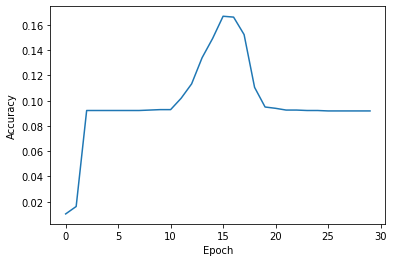

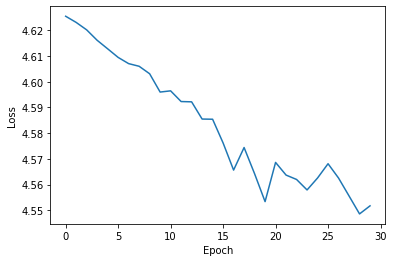

In [10]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

accuracies = []
losses = []

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Evaluate network on validation set
  accuracy = evaluate_neural_network_on_validation_set(net) 
  accuracies.append( (epoch, accuracy) )
  losses.append( (epoch, loss) )

  # Step the scheduler
  scheduler.step()

output.clear()
plot_accuracies_and_losses(accuracies, losses)

**Train Neural Network from scratch with Hyperparameters Tuning**


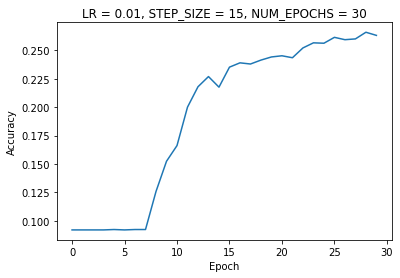

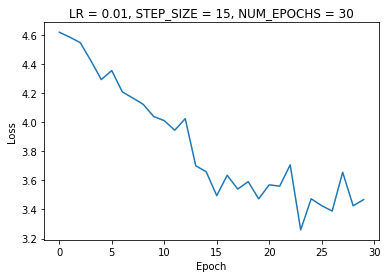

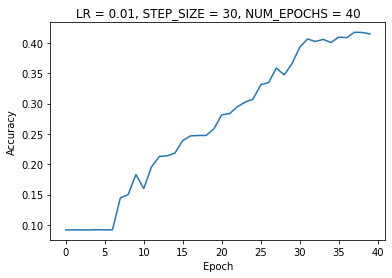

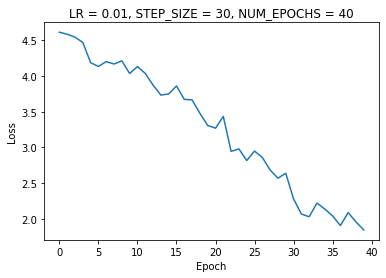

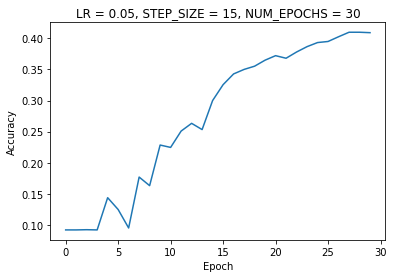

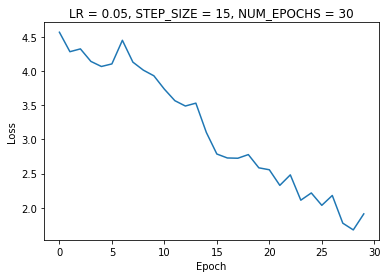

In [12]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = load_default_parameters()

# Load sets of hyperparameters
# (LR, STEP_SIZE, NUM_EPOCHS)
hyperparameters_sets = load_hyperparameters_sets()

# Define structures for accuracies and losses
accuracies = dict()
losses = dict()
nets_best_accuracy = dict()

for hyperparameter_set in hyperparameters_sets:
  # Set LR, STEP_SIZE and NUM_EPOCHS 
  LR = hyperparameter_set[0]
  STEP_SIZE = hyperparameter_set[1]
  NUM_EPOCHS = hyperparameter_set[2]

  # Initialize structures for accuracies and losses
  print("\nHyperparameter set:")
  print(hyperparameter_set)
  accuracies[hyperparameter_set] = []
  losses[hyperparameter_set] = []
  
  # Prepare Network
  net = alexnet() 
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  # Prepare Training
  criterion = nn.CrossEntropyLoss() 
  parameters_to_optimize = net.parameters() 
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  net = net.to(DEVICE) 

  cudnn.benchmark 

  current_step = 0
  best_accuracy = float(0)
  filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    for images, labels in train_dataloader:

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()  
      optimizer.step() 
      current_step += 1

    scheduler.step()
    
    # Evaluate network on validation set, save accuracy and loss
    accuracy = evaluate_neural_network_on_validation_set(net) 
    accuracies[hyperparameter_set].append( (epoch, accuracy) )
    losses[hyperparameter_set].append( (epoch, loss.item()))
    
    # Save the model if this epoch produced the best accuracy value on validation set
    if accuracy > best_accuracy:
      torch.save(net.state_dict(), filename)
      nets_best_accuracy[hyperparameter_set] = (epoch, accuracy, filename)
      best_accuracy = accuracy

  output.clear()

# Plot results
for hyperparameter_set in hyperparameters_sets:
  plot_accuracies_and_losses(accuracies[hyperparameter_set],losses[hyperparameter_set], 
                             "LR = " + str(hyperparameter_set[0]) + ", " + 
                             "STEP_SIZE = " + str(hyperparameter_set[1]) + ", " + 
                             "NUM_EPOCHS = " + str(hyperparameter_set[2]))


**Validation on Neural Network trained from scratch**

In [13]:
# Get best model found at its best epoch
max_acc = 0
max_acc_model_filename = ""
for k in nets_best_accuracy:
  if nets_best_accuracy[k][1] > max_acc:
    max_acc = nets_best_accuracy[k][1]
    max_acc_model_filename = nets_best_accuracy[k][2]

net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
net.load_state_dict(torch.load(max_acc_model_filename))

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

output.clear()
print('\nValidation Accuracy: {}'.format(accuracy))


Validation Accuracy: 0.4174153420870767


**Test on Neural Network trained from scratch**

In [14]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

output.clear()
print('\nTest Accuracy: {}'.format(accuracy))


Test Accuracy: 0.4255098513653647


**Transfer Learning - AlexNet pretrained with hyperparameters tuning**

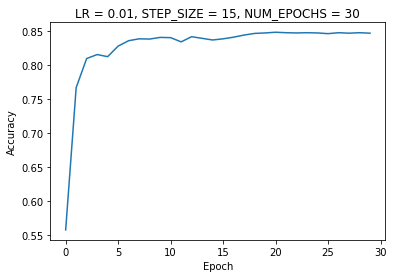

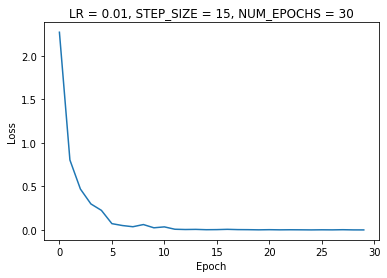

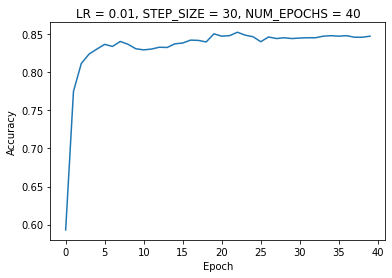

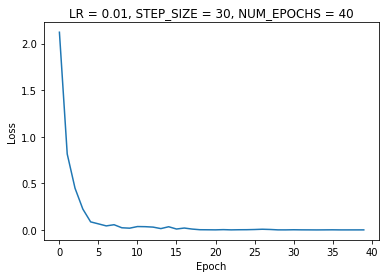

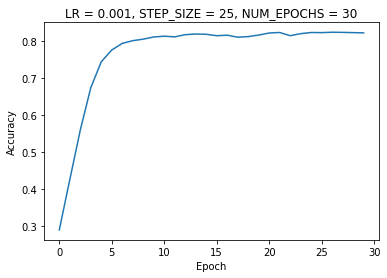

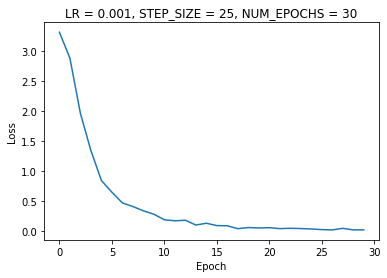

In [15]:
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = load_default_parameters()

# Load sets of hyperparameters
# (LR, STEP_SIZE, NUM_EPOCHS)
hyperparameters_sets = load_hyperparameters_sets_for_pretrained_net()

train_transform, eval_transform = load_alexnet_pretrained_transformations()

# Define structures for accuracies and losses
accuracies = dict()
losses = dict()
nets_best_accuracy = dict()

for hyperparameter_set in hyperparameters_sets:
  # Set LR, STEP_SIZE and NUM_EPOCHS 
  LR = hyperparameter_set[0]
  STEP_SIZE = hyperparameter_set[1]
  NUM_EPOCHS = hyperparameter_set[2]

  # Initialize structures for accuracies and losses
  print("\n Hyperparameter set:")
  print(hyperparameter_set)
  accuracies[hyperparameter_set] = []
  losses[hyperparameter_set] = []
  
  # Prepare Network
  net = alexnet(pretrained=True)
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  # Prepare Training
  criterion = nn.CrossEntropyLoss()
  parameters_to_optimize = net.parameters() 
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  net = net.to(DEVICE)

  cudnn.benchmark 

  current_step = 0
  best_accuracy = float(0)
  filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    for images, labels in train_dataloader:

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()  
      optimizer.step() 
      current_step += 1

    scheduler.step()

    # Evaluate network on validation set, save accuracy and loss
    accuracy = evaluate_neural_network_on_validation_set(net) 
    accuracies[hyperparameter_set].append( (epoch, accuracy) )
    losses[hyperparameter_set].append( (epoch, loss.item()))
    
    # Save the model if this epoch produced the best accuracy value on validation set
    if accuracy > best_accuracy:
      torch.save(net.state_dict(), filename)
      nets_best_accuracy[hyperparameter_set] = (epoch, accuracy, filename)
      best_accuracy = accuracy

  output.clear()

# Plot results
for hyperparameter_set in hyperparameters_sets:
  plot_accuracies_and_losses(accuracies[hyperparameter_set],losses[hyperparameter_set], 
                             "LR = " + str(hyperparameter_set[0]) + ", " + 
                             "STEP_SIZE = " + str(hyperparameter_set[1]) + ", " + 
                             "NUM_EPOCHS = " + str(hyperparameter_set[2]))

**Freezing of**
FC layers and Convolutional Layers

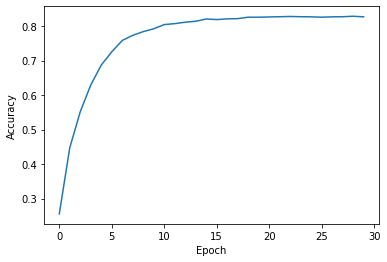

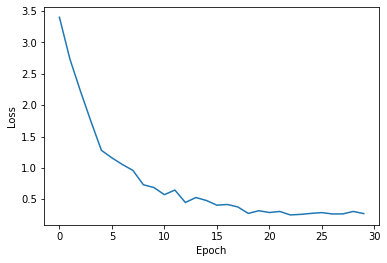

In [16]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = load_default_parameters()

# Define structures for accuracies and losses
losses = []
accuracies = []

# Prepare Network
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

# Train only FC layers -> Freeze convolutional Layers
for param in net.features.parameters():
  param.requires_grad = False
  
# Prepare Training
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE)

cudnn.benchmark 

current_step = 0

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  for images, labels in train_dataloader:

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()  
    optimizer.step() 

    current_step += 1

  scheduler.step()
  
  # Evaluate network on validation set, save accuracy and loss
  accuracy = evaluate_neural_network_on_validation_set(net) 
  accuracies.append( (epoch, accuracy) )
  losses.append( (epoch, loss.item()))
    
output.clear()

# Plot results
plot_accuracies_and_losses(accuracies, losses)


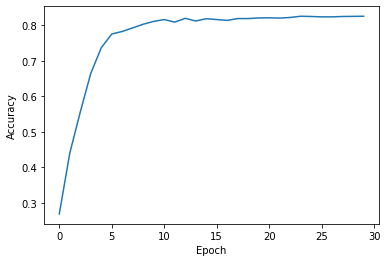

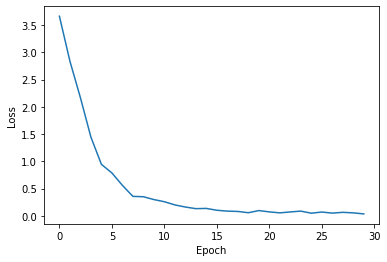

In [17]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = load_default_parameters()

# Define structures for accuracies and losses
losses = []
accuracies = []

# Prepare Network
net = alexnet(pretrained=True)

# Train only convolutional layers -> Freeze FC layers
for param in net.classifier.parameters():
  param.requires_grad = False

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
  
# Prepare Training
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE)

cudnn.benchmark 

current_step = 0

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  for images, labels in train_dataloader:

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()  
    optimizer.step() 

    current_step += 1

  scheduler.step()
  
  # Evaluate network on validation set, save accuracy and loss
  accuracy = evaluate_neural_network_on_validation_set(net) 
  accuracies.append( (epoch, accuracy) )
  losses.append( (epoch, loss.item()))
    
output.clear()

# Plot results
plot_accuracies_and_losses(accuracies, losses)


**Data augmentation**

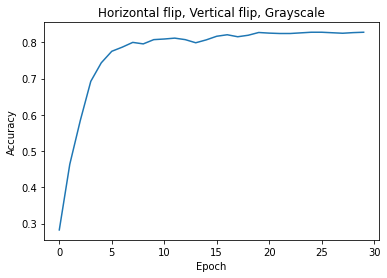

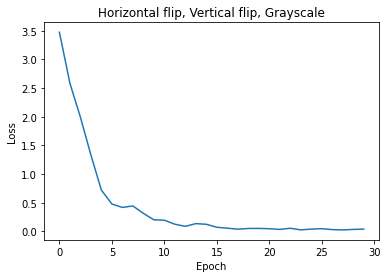

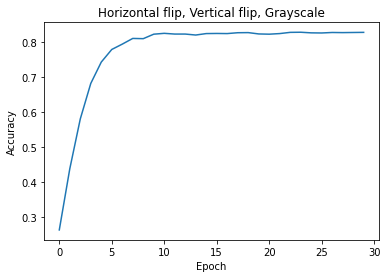

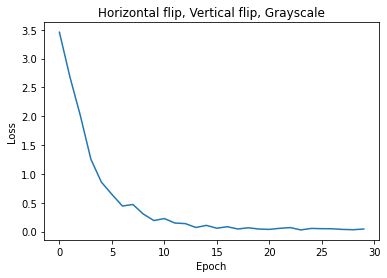

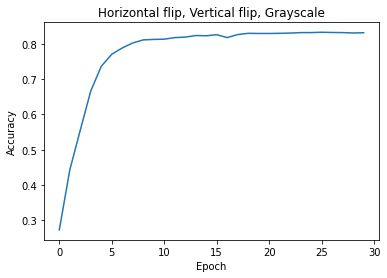

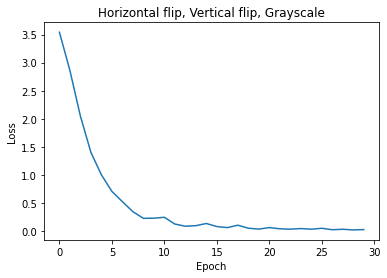

In [24]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = load_default_parameters()

# Load sets of transformations
# (train_transform, eval_transform)
transformations_sets = load_transformations_for_data_augmentation()

# Define structures for accuracies and losses
accuracies = dict()
losses = dict()
nets_best_accuracy = dict()

print(transformations_sets)

for transformations_set in transformations_sets:
  train_transform = transformations_set[0]
  eval_transform = transformations_set[1]
  title = transformations_set[2]

  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

  # Initialize structures for accuracies and losses
  accuracies[transformations_set] = []
  losses[transformations_set] = []
  
  # Prepare Network
  net = alexnet(pretrained=True)
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  # Prepare Training
  criterion = nn.CrossEntropyLoss()
  parameters_to_optimize = net.parameters() 
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  net = net.to(DEVICE)

  cudnn.benchmark 

  current_step = 0
  best_accuracy = float(0)
  filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    for images, labels in train_dataloader:

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()  
      optimizer.step() 
      current_step += 1

    scheduler.step()

    # Evaluate network on validation set, save accuracy and loss
    accuracy = evaluate_neural_network_on_validation_set(net) 
    accuracies[transformations_set].append( (epoch, accuracy) )
    losses[transformations_set].append( (epoch, loss.item()))
    
    # Save the model if this epoch produced the best accuracy value on validation set
    if accuracy > best_accuracy:
      torch.save(net.state_dict(), filename)
      nets_best_accuracy[transformations_set] = (epoch, accuracy, filename)
      best_accuracy = accuracy

  output.clear()

# Plot results
for transformations_set in transformations_sets:
  plot_accuracies_and_losses(accuracies[transformations_set],losses[transformations_set], title)